In [726]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [727]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random

In [728]:
data_train = "Data_Train.csv"
data_test = "Data_Test.csv"
add_synopsis = False

In [729]:
df = pd.read_csv("Data/" + data_train)
df_testing = pd.read_csv("Data/" + data_test)
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


Text variables : Title, sysnopsis

Categorical : Author, genre, bookCategory

composite (categorical) : Edition

real valued: Reviews, ratings

In [730]:
df.shape

(6237, 9)

In [731]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [732]:
df = prepare_data(df)
df.to_csv("Data/new_data.csv", index=None)
data = pd.read_csv("Data/new_data.csv")
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


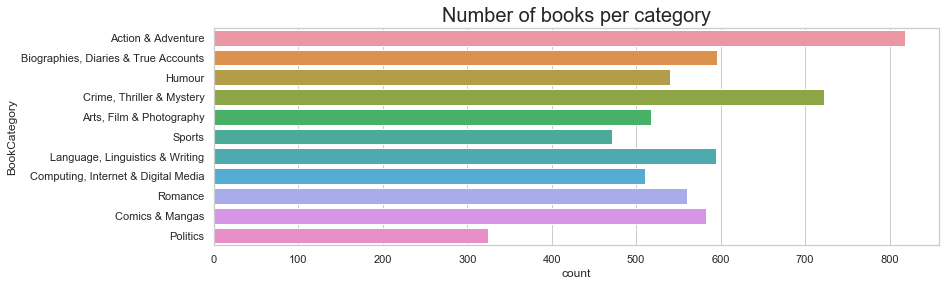

In [733]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=data).set_title("Number of books per category",fontsize=20)
plt.show()

### Converting BookCategory to one hot vector

In [734]:
dummies = pd.get_dummies(data['BookCategory'])
data = pd.concat([data, dummies], axis=1)
data.shape

(6237, 21)

Text(0.5, 1.0, 'Price of Books vs reviews')

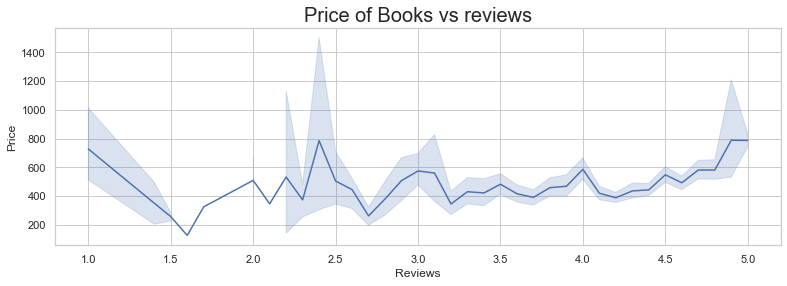

In [735]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

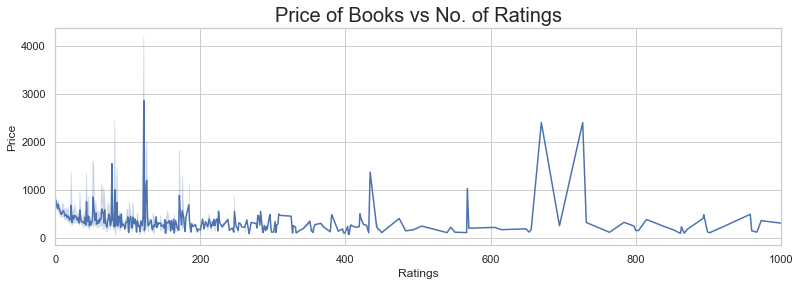

In [736]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

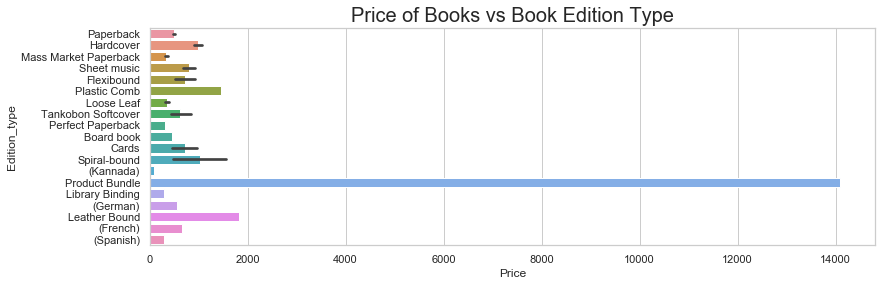

In [737]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

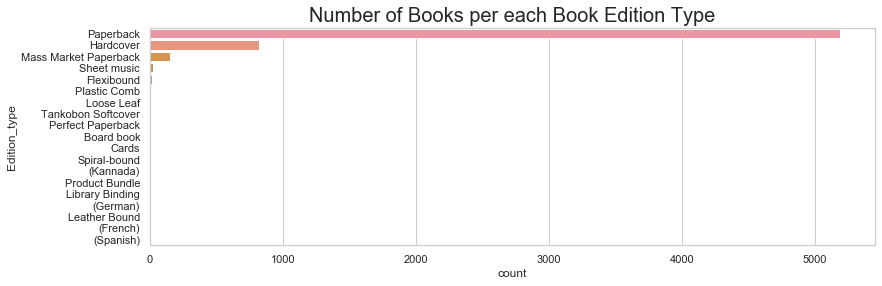

In [738]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

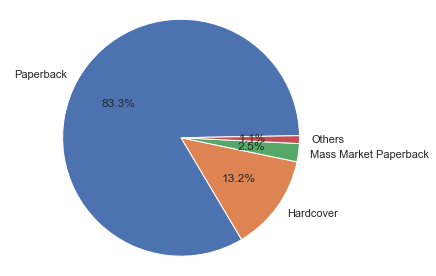

In [739]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

##### Since top 3-4 categories cover more than 97% of the data, we convert other categories to "others"

In [740]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"
dummies = pd.get_dummies(data['Edition_type'])
data = pd.concat([data, dummies], axis=1)
data.shape

(6237, 25)

In [741]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"
dummies2 = pd.get_dummies(data['Genre'])
data = pd.concat([data, dummies2], axis=1)
data.shape

(6237, 133)

In [742]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"
dummies2 = pd.get_dummies(data['Author'])
data = pd.concat([data, dummies2], axis=1)
data.shape

(6237, 508)

In [743]:
data = data.drop(columns=['Author', 'Genre', 'Edition_type', 'BookCategory', 'Edition_year'])

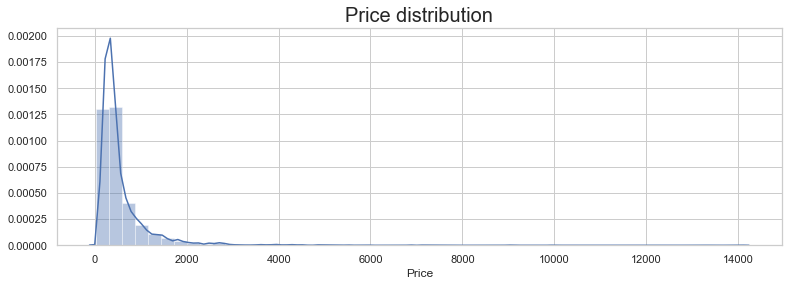

In [744]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

#### As we can see that the price distribution is a bit skewed, and there are several outliers as well.

In [745]:
# Removing outliers
data = data.loc[(data['Price'] <= 1500) & (data['Price'] >=100)]

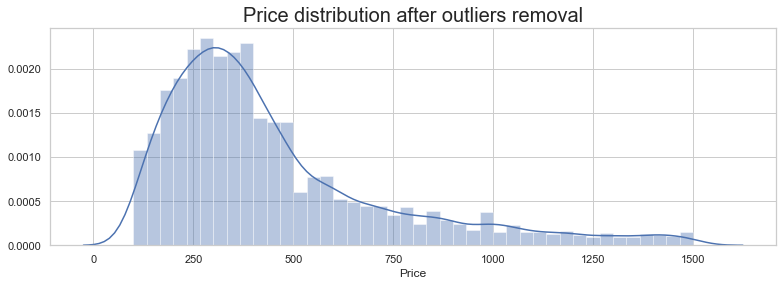

In [746]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution after outliers removal", fontsize=20)
plt.show()

In [747]:
data.shape

(5728, 503)

### Add Synopsis as average word vectors to the features

In [748]:
if add_synopsis:    
    stemmer = stem.PorterStemmer()
    stop_words = stopwords.words('english')

    def stem_stop(input_text):
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(input_text.lower())
        tokens = [x for x in tokens if not x in stop_words]
        tokens_stemmed = [stemmer.stem(x) for x in tokens]
        return tokens_stemmed

    def get_mean_vector(word2vec_model, words):
        words = [word for word in words if word in word2vec_model.vocab]
        if len(words) >= 1:
            return np.mean(word2vec_model[words], axis=0)
        else:
            return np.zeroes(300)

    def get_word_vectors(df):
        sentences_train = list(df)
        sentences_train = [stem_stop(i) for i in sentences_train]
        sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
        headers = ["Wordvec"+ str(i) for i in range(300)]
    #     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
        return sentences_train


    model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
    sentences = get_word_vectors(data['Synopsis'])
    headers = ["Wordvec"+ str(i) for i in range(300)]
    sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
    data = pd.concat([data, sentences], axis=1)

In [749]:
data = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((5728, 501), Index(['Reviews', 'Ratings', 'Price', 'Action & Adventure',
        'Arts, Film & Photography', 'Biographies, Diaries & True Accounts',
        'Comics & Mangas', 'Computing, Internet & Digital Media',
        'Crime, Thriller & Mystery', 'Humour',
        ...
        'Walter Isaacson', 'Wilbur Smith', 'William Dalrymple',
        'William Lidwell', 'William Shakespeare', 'Wonder House Books',
        'Yashavant P. Kanetkar', 'Yashodhara Lal', 'Yuval Noah Harari',
        'ZAG Entertainment'],
       dtype='object', length=501))

In [750]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using Binary encoding for categorical variables

In [751]:
# ce_bin = ce.BinaryEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
# X = ce_bin.fit_transform(X, Y)

In [752]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4582, 500), (1146, 500), (4582,), (1146,))

#### importing Decision tree regressor with max depth = 3

In [753]:
# reg_model = DecisionTreeRegressor(max_depth=20)

# reg_model.fit(x_train, y_train)

# print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

# predictions = list(reg_model.predict(x_test))

# print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

In [754]:
def plot_train_test_error(x_train, y_train, x_test, y_test, encoding_type):

    train_errors, test_errors, depths = [], [], []

    for depth in range(2, 30):
        reg_model = DecisionTreeRegressor(max_depth=depth)
        reg_model.fit(x_train, y_train)
        train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
        test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
        train_errors.append(train_err)
        test_errors.append(test_err)
        depths.append(depth)

    d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

    builds = d['depths']
    y_stack = np.row_stack((d['train_error'], d['test_error'])) 
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Train test error with ' + encoding_type + ' encoded categorical Variables', fontsize=15)
    ax1 = fig.add_subplot(111)

    ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
    ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

    plt.xticks(builds)
    plt.xlabel('Depth')
    plt.ylabel('Error')

    handles, labels = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
    ax1.grid('on')

    plt.show()

#### Plot train test error for Decision tree regressor with varying max depths

In [755]:
# plot_train_test_error(x_train, y_train, x_test, y_test, 'Binary')

#### Trying multi-layer perceptron regressor

In [756]:
reg_model = MLPRegressor(verbose=True, max_iter=6000, learning_rate_init=0.001, hidden_layer_sizes=(100,))

In [757]:
reg_model.fit(x_train, y_train)

Iteration 1, loss = 146879.02723158
Iteration 2, loss = 146642.43875270
Iteration 3, loss = 146287.03390571
Iteration 4, loss = 145786.72628316
Iteration 5, loss = 145129.53082165
Iteration 6, loss = 144304.08824314
Iteration 7, loss = 143317.31043655
Iteration 8, loss = 142163.18105512
Iteration 9, loss = 140839.80745028
Iteration 10, loss = 139360.32975125
Iteration 11, loss = 137725.53111461
Iteration 12, loss = 135944.07071992
Iteration 13, loss = 134029.30719057
Iteration 14, loss = 131982.63027848
Iteration 15, loss = 129824.76312092
Iteration 16, loss = 127550.04556397
Iteration 17, loss = 125173.17665874
Iteration 18, loss = 122709.15718852
Iteration 19, loss = 120168.94787645
Iteration 20, loss = 117545.00525498
Iteration 21, loss = 114876.69629848
Iteration 22, loss = 112151.28814076
Iteration 23, loss = 109383.52573734
Iteration 24, loss = 106600.35167420
Iteration 25, loss = 103783.16254465
Iteration 26, loss = 100967.43534641
Iteration 27, loss = 98150.67790509
Iteration 2

Iteration 227, loss = 32143.37566304
Iteration 228, loss = 32121.10521286
Iteration 229, loss = 32095.65080156
Iteration 230, loss = 32071.79427298
Iteration 231, loss = 32046.91280117
Iteration 232, loss = 32023.13911984
Iteration 233, loss = 32000.46950687
Iteration 234, loss = 31979.81350247
Iteration 235, loss = 31953.37546013
Iteration 236, loss = 31931.71669752
Iteration 237, loss = 31910.68889288
Iteration 238, loss = 31885.87085534
Iteration 239, loss = 31861.73576022
Iteration 240, loss = 31839.63168518
Iteration 241, loss = 31819.52827797
Iteration 242, loss = 31797.70485618
Iteration 243, loss = 31776.09324678
Iteration 244, loss = 31752.61772611
Iteration 245, loss = 31734.01881188
Iteration 246, loss = 31710.93912859
Iteration 247, loss = 31687.91944308
Iteration 248, loss = 31668.95384379
Iteration 249, loss = 31646.95260876
Iteration 250, loss = 31625.82210273
Iteration 251, loss = 31605.95947206
Iteration 252, loss = 31584.78653086
Iteration 253, loss = 31566.48267559
I

Iteration 450, loss = 29045.68906572
Iteration 451, loss = 29036.19791723
Iteration 452, loss = 29026.23364173
Iteration 453, loss = 29017.81989528
Iteration 454, loss = 29010.93173618
Iteration 455, loss = 29001.53476299
Iteration 456, loss = 28992.78489168
Iteration 457, loss = 28985.61123438
Iteration 458, loss = 28975.66109183
Iteration 459, loss = 28969.83029885
Iteration 460, loss = 28959.17732302
Iteration 461, loss = 28949.88473757
Iteration 462, loss = 28943.33043309
Iteration 463, loss = 28934.61451485
Iteration 464, loss = 28931.15416067
Iteration 465, loss = 28916.77658785
Iteration 466, loss = 28910.88147710
Iteration 467, loss = 28906.83453625
Iteration 468, loss = 28894.40009121
Iteration 469, loss = 28885.90922017
Iteration 470, loss = 28879.29120221
Iteration 471, loss = 28872.65353659
Iteration 472, loss = 28860.49183662
Iteration 473, loss = 28852.31644919
Iteration 474, loss = 28845.46340404
Iteration 475, loss = 28836.27314653
Iteration 476, loss = 28834.19316568
I

Iteration 672, loss = 27677.64581199
Iteration 673, loss = 27676.08355167
Iteration 674, loss = 27669.11181336
Iteration 675, loss = 27665.74665574
Iteration 676, loss = 27661.27123986
Iteration 677, loss = 27663.17459638
Iteration 678, loss = 27652.42278078
Iteration 679, loss = 27652.24985534
Iteration 680, loss = 27642.78169079
Iteration 681, loss = 27639.77066238
Iteration 682, loss = 27636.62579055
Iteration 683, loss = 27634.43453882
Iteration 684, loss = 27631.53586176
Iteration 685, loss = 27621.48677353
Iteration 686, loss = 27619.86072732
Iteration 687, loss = 27617.21311450
Iteration 688, loss = 27611.00292135
Iteration 689, loss = 27605.84719390
Iteration 690, loss = 27604.43382006
Iteration 691, loss = 27597.96093279
Iteration 692, loss = 27597.06554403
Iteration 693, loss = 27593.62139494
Iteration 694, loss = 27590.75350396
Iteration 695, loss = 27581.85601841
Iteration 696, loss = 27580.64797587
Iteration 697, loss = 27577.18866835
Iteration 698, loss = 27569.55673440
I

Iteration 894, loss = 26955.83435882
Iteration 895, loss = 26950.06689763
Iteration 896, loss = 26948.99511700
Iteration 897, loss = 26948.75272136
Iteration 898, loss = 26948.54463363
Iteration 899, loss = 26944.50687680
Iteration 900, loss = 26939.20082117
Iteration 901, loss = 26937.86597320
Iteration 902, loss = 26934.42692194
Iteration 903, loss = 26933.54158052
Iteration 904, loss = 26930.04754145
Iteration 905, loss = 26928.50728777
Iteration 906, loss = 26930.77711561
Iteration 907, loss = 26925.47493201
Iteration 908, loss = 26922.35155297
Iteration 909, loss = 26917.32768593
Iteration 910, loss = 26915.73499969
Iteration 911, loss = 26913.91545882
Iteration 912, loss = 26913.79082198
Iteration 913, loss = 26911.03832142
Iteration 914, loss = 26908.15873300
Iteration 915, loss = 26908.10664727
Iteration 916, loss = 26900.05739645
Iteration 917, loss = 26899.11023745
Iteration 918, loss = 26896.48214162
Iteration 919, loss = 26898.44923448
Iteration 920, loss = 26894.57317201
I

Iteration 1114, loss = 26512.89966448
Iteration 1115, loss = 26512.37957440
Iteration 1116, loss = 26510.65798756
Iteration 1117, loss = 26511.39414599
Iteration 1118, loss = 26510.74395232
Iteration 1119, loss = 26503.54577420
Iteration 1120, loss = 26506.70374245
Iteration 1121, loss = 26502.73017804
Iteration 1122, loss = 26499.22873071
Iteration 1123, loss = 26500.49322923
Iteration 1124, loss = 26503.21006684
Iteration 1125, loss = 26493.52315068
Iteration 1126, loss = 26491.88877057
Iteration 1127, loss = 26490.80706089
Iteration 1128, loss = 26490.86972415
Iteration 1129, loss = 26487.54133342
Iteration 1130, loss = 26486.85784105
Iteration 1131, loss = 26489.85042062
Iteration 1132, loss = 26498.70481257
Iteration 1133, loss = 26481.25995555
Iteration 1134, loss = 26479.85996746
Iteration 1135, loss = 26478.43550875
Iteration 1136, loss = 26476.67598251
Iteration 1137, loss = 26477.48001002
Iteration 1138, loss = 26478.79348405
Iteration 1139, loss = 26470.11057831
Iteration 11

Iteration 1330, loss = 26192.60551266
Iteration 1331, loss = 26194.66401318
Iteration 1332, loss = 26192.13332080
Iteration 1333, loss = 26187.14524145
Iteration 1334, loss = 26186.90562752
Iteration 1335, loss = 26187.22196806
Iteration 1336, loss = 26186.79899092
Iteration 1337, loss = 26185.00725694
Iteration 1338, loss = 26186.39646299
Iteration 1339, loss = 26182.87259766
Iteration 1340, loss = 26178.45922474
Iteration 1341, loss = 26180.58561202
Iteration 1342, loss = 26179.80806344
Iteration 1343, loss = 26177.72916423
Iteration 1344, loss = 26173.34710630
Iteration 1345, loss = 26173.83320998
Iteration 1346, loss = 26172.91897499
Iteration 1347, loss = 26171.90120858
Iteration 1348, loss = 26169.88426162
Iteration 1349, loss = 26167.09465058
Iteration 1350, loss = 26165.90367419
Iteration 1351, loss = 26166.14839512
Iteration 1352, loss = 26174.66595574
Iteration 1353, loss = 26165.37447432
Iteration 1354, loss = 26162.20891861
Iteration 1355, loss = 26160.68675107
Iteration 13

Iteration 1546, loss = 25943.16520546
Iteration 1547, loss = 25938.67282795
Iteration 1548, loss = 25931.60534113
Iteration 1549, loss = 25941.21505995
Iteration 1550, loss = 25932.69975028
Iteration 1551, loss = 25928.03254190
Iteration 1552, loss = 25932.44975653
Iteration 1553, loss = 25926.44064897
Iteration 1554, loss = 25928.51188035
Iteration 1555, loss = 25934.38942581
Iteration 1556, loss = 25922.36295792
Iteration 1557, loss = 25921.69391397
Iteration 1558, loss = 25923.89734601
Iteration 1559, loss = 25931.19901714
Iteration 1560, loss = 25925.89619244
Iteration 1561, loss = 25918.09711221
Iteration 1562, loss = 25918.85973111
Iteration 1563, loss = 25913.59296218
Iteration 1564, loss = 25916.84357542
Iteration 1565, loss = 25914.36032241
Iteration 1566, loss = 25912.17086012
Iteration 1567, loss = 25910.25169757
Iteration 1568, loss = 25909.45342688
Iteration 1569, loss = 25910.33604879
Iteration 1570, loss = 25910.95279138
Iteration 1571, loss = 25911.56790742
Iteration 15

Iteration 1762, loss = 25710.05878346
Iteration 1763, loss = 25714.71381935
Iteration 1764, loss = 25709.06594048
Iteration 1765, loss = 25706.82740315
Iteration 1766, loss = 25716.83290012
Iteration 1767, loss = 25714.53320232
Iteration 1768, loss = 25705.50727731
Iteration 1769, loss = 25703.72143399
Iteration 1770, loss = 25703.16962918
Iteration 1771, loss = 25706.07677231
Iteration 1772, loss = 25699.51172487
Iteration 1773, loss = 25705.91617515
Iteration 1774, loss = 25697.44868687
Iteration 1775, loss = 25698.15515190
Iteration 1776, loss = 25696.39399042
Iteration 1777, loss = 25695.32606365
Iteration 1778, loss = 25712.05335785
Iteration 1779, loss = 25696.95839845
Iteration 1780, loss = 25693.55563789
Iteration 1781, loss = 25692.30342532
Iteration 1782, loss = 25689.62562976
Iteration 1783, loss = 25691.97715906
Iteration 1784, loss = 25687.67396089
Iteration 1785, loss = 25689.19127578
Iteration 1786, loss = 25687.10922231
Iteration 1787, loss = 25685.44714226
Iteration 17

Iteration 1979, loss = 25498.14118320
Iteration 1980, loss = 25500.00197653
Iteration 1981, loss = 25494.94039406
Iteration 1982, loss = 25498.67785963
Iteration 1983, loss = 25492.17490785
Iteration 1984, loss = 25494.16236927
Iteration 1985, loss = 25491.09266756
Iteration 1986, loss = 25493.31481056
Iteration 1987, loss = 25491.21100630
Iteration 1988, loss = 25490.85423244
Iteration 1989, loss = 25486.84585401
Iteration 1990, loss = 25489.00805589
Iteration 1991, loss = 25489.27774744
Iteration 1992, loss = 25485.05613996
Iteration 1993, loss = 25495.90417971
Iteration 1994, loss = 25479.94555014
Iteration 1995, loss = 25488.61242673
Iteration 1996, loss = 25478.61759044
Iteration 1997, loss = 25484.24065773
Iteration 1998, loss = 25479.20855279
Iteration 1999, loss = 25478.67835518
Iteration 2000, loss = 25477.40240423
Iteration 2001, loss = 25477.35527389
Iteration 2002, loss = 25476.44587618
Iteration 2003, loss = 25472.83896500
Iteration 2004, loss = 25473.89975578
Iteration 20

Iteration 2195, loss = 25296.32372377
Iteration 2196, loss = 25294.60025636
Iteration 2197, loss = 25293.90762625
Iteration 2198, loss = 25293.10424980
Iteration 2199, loss = 25292.94264275
Iteration 2200, loss = 25289.71127967
Iteration 2201, loss = 25291.34718723
Iteration 2202, loss = 25293.30575514
Iteration 2203, loss = 25285.96465420
Iteration 2204, loss = 25286.36235213
Iteration 2205, loss = 25285.59536462
Iteration 2206, loss = 25284.26845776
Iteration 2207, loss = 25282.90989323
Iteration 2208, loss = 25281.97477269
Iteration 2209, loss = 25280.99710595
Iteration 2210, loss = 25285.63550628
Iteration 2211, loss = 25278.83022602
Iteration 2212, loss = 25278.35026634
Iteration 2213, loss = 25279.89992258
Iteration 2214, loss = 25276.46260159
Iteration 2215, loss = 25275.16642821
Iteration 2216, loss = 25273.09006718
Iteration 2217, loss = 25276.29072506
Iteration 2218, loss = 25273.85212487
Iteration 2219, loss = 25272.13214399
Iteration 2220, loss = 25270.71739162
Iteration 22

Iteration 2411, loss = 25105.35498715
Iteration 2412, loss = 25102.91019192
Iteration 2413, loss = 25100.82850794
Iteration 2414, loss = 25101.72382695
Iteration 2415, loss = 25101.01929919
Iteration 2416, loss = 25102.24721496
Iteration 2417, loss = 25100.35304047
Iteration 2418, loss = 25099.08863707
Iteration 2419, loss = 25094.05592356
Iteration 2420, loss = 25101.80409172
Iteration 2421, loss = 25105.87945970
Iteration 2422, loss = 25098.49523181
Iteration 2423, loss = 25091.26114138
Iteration 2424, loss = 25089.59485772
Iteration 2425, loss = 25091.74653213
Iteration 2426, loss = 25087.88236741
Iteration 2427, loss = 25091.67335340
Iteration 2428, loss = 25085.70664363
Iteration 2429, loss = 25088.75748359
Iteration 2430, loss = 25083.87936367
Iteration 2431, loss = 25085.26582104
Iteration 2432, loss = 25087.28207797
Iteration 2433, loss = 25084.85310933
Iteration 2434, loss = 25084.84896592
Iteration 2435, loss = 25084.53680808
Iteration 2436, loss = 25084.20848410
Iteration 24

Iteration 2627, loss = 24917.81148519
Iteration 2628, loss = 24916.87362740
Iteration 2629, loss = 24918.31161843
Iteration 2630, loss = 24914.66731964
Iteration 2631, loss = 24918.51521134
Iteration 2632, loss = 24914.42983647
Iteration 2633, loss = 24915.20175799
Iteration 2634, loss = 24913.51197819
Iteration 2635, loss = 24911.64631797
Iteration 2636, loss = 24909.71122671
Iteration 2637, loss = 24908.89534089
Iteration 2638, loss = 24910.03255871
Iteration 2639, loss = 24911.33880032
Iteration 2640, loss = 24914.03846129
Iteration 2641, loss = 24912.39527699
Iteration 2642, loss = 24905.33227282
Iteration 2643, loss = 24907.66628258
Iteration 2644, loss = 24902.99702099
Iteration 2645, loss = 24903.64596333
Iteration 2646, loss = 24906.01146147
Iteration 2647, loss = 24905.10780039
Iteration 2648, loss = 24901.86935690
Iteration 2649, loss = 24914.97584261
Iteration 2650, loss = 24896.73366470
Iteration 2651, loss = 24899.19056956
Iteration 2652, loss = 24898.30737793
Iteration 26

Iteration 2843, loss = 24741.47523761
Iteration 2844, loss = 24742.29226805
Iteration 2845, loss = 24739.20578317
Iteration 2846, loss = 24737.18564411
Iteration 2847, loss = 24742.86103586
Iteration 2848, loss = 24734.88269493
Iteration 2849, loss = 24737.52061878
Iteration 2850, loss = 24736.58447366
Iteration 2851, loss = 24734.19868662
Iteration 2852, loss = 24732.12818861
Iteration 2853, loss = 24731.27829642
Iteration 2854, loss = 24733.70198959
Iteration 2855, loss = 24732.33845910
Iteration 2856, loss = 24728.95718178
Iteration 2857, loss = 24731.33885953
Iteration 2858, loss = 24729.74244493
Iteration 2859, loss = 24731.79702393
Iteration 2860, loss = 24733.49341480
Iteration 2861, loss = 24727.83654740
Iteration 2862, loss = 24726.56277297
Iteration 2863, loss = 24724.23461652
Iteration 2864, loss = 24729.02260592
Iteration 2865, loss = 24722.68722283
Iteration 2866, loss = 24722.45789829
Iteration 2867, loss = 24723.23026727
Iteration 2868, loss = 24721.04541342
Iteration 28

Iteration 3059, loss = 24571.36170479
Iteration 3060, loss = 24571.90442406
Iteration 3061, loss = 24579.61572634
Iteration 3062, loss = 24568.54845507
Iteration 3063, loss = 24567.89082655
Iteration 3064, loss = 24565.87341105
Iteration 3065, loss = 24566.29663872
Iteration 3066, loss = 24565.54630392
Iteration 3067, loss = 24565.44598193
Iteration 3068, loss = 24568.34800990
Iteration 3069, loss = 24566.87675693
Iteration 3070, loss = 24562.03108746
Iteration 3071, loss = 24566.31768763
Iteration 3072, loss = 24560.62545584
Iteration 3073, loss = 24563.58088049
Iteration 3074, loss = 24557.72546447
Iteration 3075, loss = 24560.51593380
Iteration 3076, loss = 24557.94420355
Iteration 3077, loss = 24558.30225194
Iteration 3078, loss = 24556.48699084
Iteration 3079, loss = 24554.70088405
Iteration 3080, loss = 24554.49351695
Iteration 3081, loss = 24553.41667370
Iteration 3082, loss = 24561.62792655
Iteration 3083, loss = 24552.73236583
Iteration 3084, loss = 24551.29633442
Iteration 30

Iteration 3275, loss = 24406.24910276
Iteration 3276, loss = 24412.60778941
Iteration 3277, loss = 24407.74484749
Iteration 3278, loss = 24409.15936284
Iteration 3279, loss = 24402.77462757
Iteration 3280, loss = 24408.13457471
Iteration 3281, loss = 24407.44244972
Iteration 3282, loss = 24403.41556980
Iteration 3283, loss = 24402.71214943
Iteration 3284, loss = 24400.77638313
Iteration 3285, loss = 24401.00508733
Iteration 3286, loss = 24399.25877531
Iteration 3287, loss = 24400.58063280
Iteration 3288, loss = 24399.50619753
Iteration 3289, loss = 24401.34939648
Iteration 3290, loss = 24396.49039261
Iteration 3291, loss = 24397.98392868
Iteration 3292, loss = 24395.55699286
Iteration 3293, loss = 24396.40637667
Iteration 3294, loss = 24395.30653398
Iteration 3295, loss = 24395.12026456
Iteration 3296, loss = 24399.52497064
Iteration 3297, loss = 24392.59464635
Iteration 3298, loss = 24392.97991911
Iteration 3299, loss = 24392.19592088
Iteration 3300, loss = 24390.98521077
Iteration 33

Iteration 3491, loss = 24252.24143847
Iteration 3492, loss = 24253.12514516
Iteration 3493, loss = 24252.85606447
Iteration 3494, loss = 24248.16124901
Iteration 3495, loss = 24249.04498856
Iteration 3496, loss = 24247.06992513
Iteration 3497, loss = 24247.34518645
Iteration 3498, loss = 24248.41194757
Iteration 3499, loss = 24245.92456216
Iteration 3500, loss = 24245.93468269
Iteration 3501, loss = 24244.77814308
Iteration 3502, loss = 24242.97851501
Iteration 3503, loss = 24241.64042446
Iteration 3504, loss = 24245.36001523
Iteration 3505, loss = 24241.44543086
Iteration 3506, loss = 24239.67441422
Iteration 3507, loss = 24239.19272640
Iteration 3508, loss = 24238.52525530
Iteration 3509, loss = 24242.36410215
Iteration 3510, loss = 24248.07146976
Iteration 3511, loss = 24238.90113947
Iteration 3512, loss = 24236.66084423
Iteration 3513, loss = 24238.04989677
Iteration 3514, loss = 24238.56323587
Iteration 3515, loss = 24237.59360959
Iteration 3516, loss = 24234.23929094
Iteration 35

Iteration 3707, loss = 24099.69484865
Iteration 3708, loss = 24104.24096589
Iteration 3709, loss = 24098.96914628
Iteration 3710, loss = 24103.53390039
Iteration 3711, loss = 24097.77800427
Iteration 3712, loss = 24097.68848574
Iteration 3713, loss = 24098.47479132
Iteration 3714, loss = 24099.69003518
Iteration 3715, loss = 24099.33147268
Iteration 3716, loss = 24097.18304558
Iteration 3717, loss = 24093.52373594
Iteration 3718, loss = 24094.75774371
Iteration 3719, loss = 24091.27907418
Iteration 3720, loss = 24096.20515730
Iteration 3721, loss = 24092.12300741
Iteration 3722, loss = 24089.97550469
Iteration 3723, loss = 24090.29736702
Iteration 3724, loss = 24089.00724317
Iteration 3725, loss = 24091.06050322
Iteration 3726, loss = 24088.39199436
Iteration 3727, loss = 24087.41169186
Iteration 3728, loss = 24089.10619127
Iteration 3729, loss = 24087.71439318
Iteration 3730, loss = 24089.04573412
Iteration 3731, loss = 24083.36982135
Iteration 3732, loss = 24087.52636565
Iteration 37

Iteration 3923, loss = 23960.49919006
Iteration 3924, loss = 23961.04155843
Iteration 3925, loss = 23958.98714868
Iteration 3926, loss = 23963.66744948
Iteration 3927, loss = 23953.59369963
Iteration 3928, loss = 23957.63438710
Iteration 3929, loss = 23960.90912144
Iteration 3930, loss = 23954.35399638
Iteration 3931, loss = 23954.88051955
Iteration 3932, loss = 23956.55151705
Iteration 3933, loss = 23957.94037737
Iteration 3934, loss = 23951.95552072
Iteration 3935, loss = 23952.91755894
Iteration 3936, loss = 23953.62341683
Iteration 3937, loss = 23950.16243949
Iteration 3938, loss = 23950.85063778
Iteration 3939, loss = 23954.38567881
Iteration 3940, loss = 23947.35469782
Iteration 3941, loss = 23948.86806353
Iteration 3942, loss = 23947.07587770
Iteration 3943, loss = 23949.18341838
Iteration 3944, loss = 23946.23455476
Iteration 3945, loss = 23947.57709179
Iteration 3946, loss = 23943.31690199
Iteration 3947, loss = 23953.98049116
Iteration 3948, loss = 23942.19707395
Iteration 39

Iteration 4139, loss = 23827.22986365
Iteration 4140, loss = 23827.13126287
Iteration 4141, loss = 23826.10700852
Iteration 4142, loss = 23825.64788458
Iteration 4143, loss = 23828.27731873
Iteration 4144, loss = 23828.61050791
Iteration 4145, loss = 23827.46505261
Iteration 4146, loss = 23823.48873132
Iteration 4147, loss = 23822.35866466
Iteration 4148, loss = 23822.74018235
Iteration 4149, loss = 23823.67251892
Iteration 4150, loss = 23825.36907733
Iteration 4151, loss = 23821.89357458
Iteration 4152, loss = 23820.84063136
Iteration 4153, loss = 23817.23664444
Iteration 4154, loss = 23816.76863645
Iteration 4155, loss = 23817.23283848
Iteration 4156, loss = 23818.13206010
Iteration 4157, loss = 23818.61119700
Iteration 4158, loss = 23814.76037042
Iteration 4159, loss = 23819.34154135
Iteration 4160, loss = 23816.97389438
Iteration 4161, loss = 23818.54149563
Iteration 4162, loss = 23813.61054707
Iteration 4163, loss = 23815.88916286
Iteration 4164, loss = 23811.70481052
Iteration 41

Iteration 4355, loss = 23701.84506977
Iteration 4356, loss = 23702.62803702
Iteration 4357, loss = 23701.16395861
Iteration 4358, loss = 23700.27920058
Iteration 4359, loss = 23703.13597685
Iteration 4360, loss = 23699.59046277
Iteration 4361, loss = 23702.91145923
Iteration 4362, loss = 23697.80884295
Iteration 4363, loss = 23697.90124653
Iteration 4364, loss = 23695.81356881
Iteration 4365, loss = 23696.75219794
Iteration 4366, loss = 23697.36262523
Iteration 4367, loss = 23712.37024675
Iteration 4368, loss = 23697.79517948
Iteration 4369, loss = 23692.94732323
Iteration 4370, loss = 23694.02127015
Iteration 4371, loss = 23692.44178610
Iteration 4372, loss = 23695.42541509
Iteration 4373, loss = 23694.94831087
Iteration 4374, loss = 23692.26545852
Iteration 4375, loss = 23691.68035735
Iteration 4376, loss = 23687.94380990
Iteration 4377, loss = 23692.01910876
Iteration 4378, loss = 23690.42459618
Iteration 4379, loss = 23688.31077734
Iteration 4380, loss = 23687.92490178
Iteration 43

Iteration 4571, loss = 23586.35950911
Iteration 4572, loss = 23580.94939963
Iteration 4573, loss = 23583.28561285
Iteration 4574, loss = 23593.74766516
Iteration 4575, loss = 23581.45047383
Iteration 4576, loss = 23577.13806821
Iteration 4577, loss = 23578.69642894
Iteration 4578, loss = 23578.54610720
Iteration 4579, loss = 23577.00812491
Iteration 4580, loss = 23575.68339052
Iteration 4581, loss = 23576.28707389
Iteration 4582, loss = 23574.72254354
Iteration 4583, loss = 23573.30206119
Iteration 4584, loss = 23573.23417203
Iteration 4585, loss = 23577.22930991
Iteration 4586, loss = 23569.73797399
Iteration 4587, loss = 23570.45647905
Iteration 4588, loss = 23571.85641486
Iteration 4589, loss = 23572.10508301
Iteration 4590, loss = 23571.67127988
Iteration 4591, loss = 23570.91948920
Iteration 4592, loss = 23574.15485389
Iteration 4593, loss = 23572.23826306
Iteration 4594, loss = 23573.33999430
Iteration 4595, loss = 23566.78967338
Iteration 4596, loss = 23569.40433948
Iteration 45

Iteration 4787, loss = 23467.97658064
Iteration 4788, loss = 23465.46635382
Iteration 4789, loss = 23467.44845371
Iteration 4790, loss = 23464.68276605
Iteration 4791, loss = 23461.72079124
Iteration 4792, loss = 23462.01551122
Iteration 4793, loss = 23474.74464892
Iteration 4794, loss = 23463.71708547
Iteration 4795, loss = 23462.85269352
Iteration 4796, loss = 23462.77590365
Iteration 4797, loss = 23461.47297078
Iteration 4798, loss = 23463.13050713
Iteration 4799, loss = 23462.60503168
Iteration 4800, loss = 23457.55508248
Iteration 4801, loss = 23459.14473239
Iteration 4802, loss = 23456.38268353
Iteration 4803, loss = 23456.80581960
Iteration 4804, loss = 23458.85143078
Iteration 4805, loss = 23459.65948956
Iteration 4806, loss = 23453.53175676
Iteration 4807, loss = 23456.11724885
Iteration 4808, loss = 23455.27897982
Iteration 4809, loss = 23453.90121596
Iteration 4810, loss = 23452.03087113
Iteration 4811, loss = 23450.80318433
Iteration 4812, loss = 23451.21073122
Iteration 48

Iteration 5003, loss = 23349.32209489
Iteration 5004, loss = 23358.46863343
Iteration 5005, loss = 23356.71776846
Iteration 5006, loss = 23355.55183996
Iteration 5007, loss = 23359.56501850
Iteration 5008, loss = 23356.01011492
Iteration 5009, loss = 23353.06485285
Iteration 5010, loss = 23350.75454070
Iteration 5011, loss = 23352.28415807
Iteration 5012, loss = 23361.11540851
Iteration 5013, loss = 23351.27560665
Iteration 5014, loss = 23347.90727843
Iteration 5015, loss = 23349.00242706
Iteration 5016, loss = 23347.26614794
Iteration 5017, loss = 23350.00920390
Iteration 5018, loss = 23350.55770682
Iteration 5019, loss = 23345.89344502
Iteration 5020, loss = 23345.95469090
Iteration 5021, loss = 23346.73987033
Iteration 5022, loss = 23346.28342154
Iteration 5023, loss = 23348.12932918
Iteration 5024, loss = 23348.56590232
Iteration 5025, loss = 23344.45272852
Iteration 5026, loss = 23343.66803991
Iteration 5027, loss = 23341.17556434
Iteration 5028, loss = 23345.88104648
Iteration 50

Iteration 5219, loss = 23252.76412867
Iteration 5220, loss = 23250.12350195
Iteration 5221, loss = 23246.45660724
Iteration 5222, loss = 23250.13730273
Iteration 5223, loss = 23245.31739391
Iteration 5224, loss = 23252.31223486
Iteration 5225, loss = 23247.98183764
Iteration 5226, loss = 23255.61651280
Iteration 5227, loss = 23245.02116616
Iteration 5228, loss = 23245.65704325
Iteration 5229, loss = 23246.10758893
Iteration 5230, loss = 23242.43537188
Iteration 5231, loss = 23248.03456067
Iteration 5232, loss = 23242.33885934
Iteration 5233, loss = 23252.04817763
Iteration 5234, loss = 23244.66065751
Iteration 5235, loss = 23242.12309033
Iteration 5236, loss = 23240.37151265
Iteration 5237, loss = 23241.31231883
Iteration 5238, loss = 23240.13659242
Iteration 5239, loss = 23242.06825835
Iteration 5240, loss = 23236.00306098
Iteration 5241, loss = 23241.26636136
Iteration 5242, loss = 23246.83697640
Iteration 5243, loss = 23236.33325106
Iteration 5244, loss = 23239.09145755
Iteration 52

Iteration 5435, loss = 23149.35620478
Iteration 5436, loss = 23149.20447819
Iteration 5437, loss = 23151.60616745
Iteration 5438, loss = 23150.58821315
Iteration 5439, loss = 23152.91955514
Iteration 5440, loss = 23147.51402037
Iteration 5441, loss = 23150.48136473
Iteration 5442, loss = 23151.42784436
Iteration 5443, loss = 23146.28192681
Iteration 5444, loss = 23146.35085591
Iteration 5445, loss = 23143.70860119
Iteration 5446, loss = 23146.00521697
Iteration 5447, loss = 23144.33426983
Iteration 5448, loss = 23149.54348809
Iteration 5449, loss = 23145.41531569
Iteration 5450, loss = 23150.73702857
Iteration 5451, loss = 23149.99476983
Iteration 5452, loss = 23144.38081669
Iteration 5453, loss = 23143.39930923
Iteration 5454, loss = 23143.96435768
Iteration 5455, loss = 23142.14158175
Iteration 5456, loss = 23139.65553344
Iteration 5457, loss = 23138.94527016
Iteration 5458, loss = 23142.27048727
Iteration 5459, loss = 23139.64235638
Iteration 5460, loss = 23138.61955231
Iteration 54

Iteration 5651, loss = 23056.24580275
Iteration 5652, loss = 23055.99474090
Iteration 5653, loss = 23054.83983848
Iteration 5654, loss = 23057.01213407
Iteration 5655, loss = 23052.85548387
Iteration 5656, loss = 23056.60173920
Iteration 5657, loss = 23053.20061260
Iteration 5658, loss = 23054.77679660
Iteration 5659, loss = 23055.35947750
Iteration 5660, loss = 23051.68013513
Iteration 5661, loss = 23051.10177543
Iteration 5662, loss = 23051.48163999
Iteration 5663, loss = 23051.69355276
Iteration 5664, loss = 23053.12900560
Iteration 5665, loss = 23052.38012745
Iteration 5666, loss = 23049.41568332
Iteration 5667, loss = 23049.72862615
Iteration 5668, loss = 23050.59634249
Iteration 5669, loss = 23052.61647600
Iteration 5670, loss = 23059.16976451
Iteration 5671, loss = 23052.92186349
Iteration 5672, loss = 23050.36422521
Iteration 5673, loss = 23045.89108866
Iteration 5674, loss = 23046.30834846
Iteration 5675, loss = 23054.04807935
Iteration 5676, loss = 23045.04465911
Iteration 56

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=6000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [763]:
predictions = reg_model.predict(x_train)
predictions[predictions < 0] = 0
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, predictions)))

Train error:  0.4674837382989875


In [764]:
predictions = reg_model.predict(x_test)
predictions[predictions < 0] = 0
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.784356975656354
